## Job Recomendation Using Knowledge Graph

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules
import seaborn as sns


#### Importing Dataset

In [343]:
jd = pd.read_csv("Job Description Dataset/dice_com-job_us_sample.csv")

In [344]:
dataset = pd.read_csv("Resume_Dataset/survey_results_public.csv")

C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3369: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Cleaning
#### Creating resume subset using relavent dimensionality

In [345]:
resume_subset= dataset[['Respondent','Country','Student','CompanySize','Dependents','DevType','Gender','JobSatisfaction','LastNewJob','Salary','SalaryType','LanguageWorkedWith','DatabaseWorkedWith','PlatformWorkedWith','FrameworkWorkedWith','OperatingSystem','Age']]
df = pd.DataFrame(resume_subset)
df

Respondent             Country         Student  \
0               1               Kenya              No   
1               3      United Kingdom              No   
2               4       United States              No   
3               5       United States              No   
4               7        South Africa  Yes, part-time   
...           ...                 ...             ...   
98850      101513       United States             NaN   
98851      101531               Spain  Yes, full-time   
98852      101541               India  Yes, full-time   
98853      101544  Russian Federation              No   
98854      101548            Cambodia             NaN   

                    CompanySize Dependents  \
0            20 to 99 employees        Yes   
1      10,000 or more employees        Yes   
2            20 to 99 employees        NaN   
3          100 to 499 employees         No   
4      10,000 or more employees        Yes   
...                         ...        ...   
98850                       NaN        NaN   
98851                       NaN        NaN   
98852                       NaN        NaN   
98853                       NaN        NaN   
98854                       NaN        NaN   

                                                 DevType Gender  \
0                                   Full-stack developer   Male   
1      Database administrator;DevOps specialist;Full-...   Male   
2               Engineering manager;Full-stack developer    NaN   
3                                   Full-stack developer   Male   
4      Data or business analyst;Desktop or enterprise...   Male   
...                                                  ...    ...   
98850                                                NaN    NaN   
98851             Back-end developer;Front-end developer    NaN   
98852                                                NaN    NaN   
98853                                                NaN    NaN   
98854                                                NaN    NaN   

                          JobSatisfaction                 LastNewJob  Salary  \
0                     Extremely satisfied       Less than a year ago     NaN   
1                 Moderately dissatisfied      More than 4 years ago   51000   
2                    Moderately satisfied       Less than a year ago     NaN   
3      Neither satisfied nor dissatisfied       Less than a year ago     NaN   
4                      Slightly satisfied  Between 1 and 2 years ago  260000   
...                                   ...                        ...     ...   
98850                                 NaN                        NaN     NaN   
98851                                 NaN                        NaN     NaN   
98852                                 NaN                        NaN     NaN   
98853                                 NaN                        NaN     NaN   
98854                                 NaN                        NaN     NaN   

      SalaryType                                LanguageWorkedWith  \
0        Monthly                        JavaScript;Python;HTML;CSS   
1         Yearly                      JavaScript;Python;Bash/Shell   
2            NaN                                               NaN   
3            NaN  C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell   
4         Yearly                C;C++;Java;Matlab;R;SQL;Bash/Shell   
...          ...                                               ...   
98850        NaN                                               NaN   
98851        NaN                                               NaN   
98852        NaN                                               NaN   
98853        NaN                                               NaN   
98854        NaN                                               NaN   

                                      DatabaseWorkedWith  \
0      Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...   
1                             Redis;Postgr

#### Handling NA Values

In [346]:
resume_subset.isna().sum()

Respondent                 0
Country                  412
Student                 3954
CompanySize            27324
Dependents             36259
DevType                 6757
Gender                 34386
JobSatisfaction        29579
LastNewJob             19966
Salary                 48277
SalaryType             47785
LanguageWorkedWith     20521
DatabaseWorkedWith     32585
PlatformWorkedWith     32856
FrameworkWorkedWith    47235
OperatingSystem        22676
Age                    34281
dtype: int64

In [347]:
resume_subset.describe()

Respondent
count   98855.000000
mean    50822.971635
std     29321.650410
min         1.000000
25%     25443.500000
50%     50823.000000
75%     76219.500000
max    101592.000000

In [348]:
dataset.columns

Index(['Respondent', 'Hobby', 'OpenSource', 'Country', 'Student', 'Employment',
       'FormalEducation', 'UndergradMajor', 'CompanySize', 'DevType',
       ...
       'Exercise', 'Gender', 'SexualOrientation', 'EducationParents',
       'RaceEthnicity', 'Age', 'Dependents', 'MilitaryUS', 'SurveyTooLong',
       'SurveyEasy'],
      dtype='object', length=129)

In [349]:
resume_subset.dtypes

Respondent              int64
Country                object
Student                object
CompanySize            object
Dependents             object
DevType                object
Gender                 object
JobSatisfaction        object
LastNewJob             object
Salary                 object
SalaryType             object
LanguageWorkedWith     object
DatabaseWorkedWith     object
PlatformWorkedWith     object
FrameworkWorkedWith    object
OperatingSystem        object
Age                    object
dtype: object

In [350]:
Resume= resume_subset.dropna()
Resume

Respondent             Country         Student  \
1               3      United Kingdom              No   
6               9       United States              No   
8              11       United States              No   
17             27              Sweden              No   
20             33           Australia              No   
...           ...                 ...             ...   
71512      101569  Russian Federation              No   
71513      101570             Belgium              No   
71515      101572             Germany              No   
71524      101584       United States  Yes, full-time   
71526      101587              Canada              No   

                    CompanySize Dependents  \
1      10,000 or more employees        Yes   
6      10,000 or more employees         No   
8          100 to 499 employees        Yes   
17           10 to 19 employees        Yes   
20     1,000 to 4,999 employees        Yes   
...                         ...        ...   
71512        20 to 99 employees         No   
71513        20 to 99 employees         No   
71515        20 to 99 employees         No   
71524        20 to 99 employees         No   
71526   Fewer than 10 employees         No   

                                                 DevType Gender  \
1      Database administrator;DevOps specialist;Full-...   Male   
6      Back-end developer;Front-end developer;Full-st...   Male   
8      Back-end developer;C-suite executive (CEO, CTO...   Male   
17                                    Back-end developer   Male   
20     Database administrator;Full-stack developer;Mo...   Male   
...                                                  ...    ...   
71512                                 Back-end developer   Male   
71513  Back-end developer;Data or business analyst;De...   Male   
71515  C-suite executive (CEO, CTO, etc.);Front-end d...   Male   
71524  Back-end developer;C-suite executive (CEO, CTO...   Male   
71526  Back-end developer;Full-stack developer;Produc...   Male   

               JobSatisfaction                 LastNewJob     Salary  \
1      Moderately dissatisfied      More than 4 years ago      51000   
6           Slightly satisfied       Less than a year ago     120000   
8         Moderately satisfied  Between 2 and 4 years ago     250000   
17        Moderately satisfied  Between 1 and 2 years ago      32000   
20          Slightly satisfied  Between 2 and 4 years ago     120000   
...                        ...                        ...        ...   
71512      Extremely satisfied       Less than a year ago     100000   
71513     Moderately satisfied       Less than a year ago       3600   
71515      Extremely satisfied       Less than a year ago       2500   
71524      Extremely satisfied      More than 4 years ago     165000   
71526      Extremely satisfied  Between 1 and 2 years ago  80,000.00   

      SalaryType                                 LanguageWorkedWith  \
1         Yearly                       JavaScript;Python;Bash/Shell   
6         Yearly                                JavaScript;HTML;CSS   
8         Yearly  Assembly;CoffeeScript;Erlang;Go;JavaScript;Lua...   
17       Monthly                         C#;SQL;HTML;CSS;Bash/Shell   
20        Yearly                          C;C++;Go;Python;SQL;Swift   
...          ...                                                ...   
71512    Monthly                                           Java;SQL   
71513    Monthly  CoffeeScript;Clojure;JavaScript;PHP;Rust;SQL;H...   
71515    Monthly  CoffeeScript;JavaScript;PHP;SQL;HTML;CSS;Bash/...   
71524     Yearly  C#;Clojure;Go;Java;JavaScript;PHP;R;SQL;HTML;C...   
71526     Yearly       C#;Go;Java;JavaScript;PHP;SQL;Swift;HTML;CSS   

                                      DatabaseWorkedWith  \
1                             Redis;PostgreSQL;Memcached   
6                                                MongoDB   
8      Redis;PostgreSQL;Amazon DynamoDB;Apache HBase;...   
17    

#### Data Cleaning : DevType

In [351]:
Resume['DevType'].value_counts()

Full-stack developer                                                                                                                                                                                     1541
Back-end developer;Front-end developer;Full-stack developer                                                                                                                                              1286
Back-end developer                                                                                                                                                                                       1272
Back-end developer;Full-stack developer                                                                                                                                                                   900
Front-end developer                                                                                                                                                             

Removing dev type category having less than 100 entries in dataset

In [352]:
Resume.iloc[0]['DevType']

'Database administrator;DevOps specialist;Full-stack developer;System administrator'

In [353]:
Devtype_value= Resume['DevType'].value_counts()
Resume2= Resume.copy()
Resume2['DevType'] = Resume2['DevType'].str.replace(';',',')
Resume2['DevType'] = Resume2[[Resume2.columns[5]]].values.tolist()

for index,data in Resume2.iterrows():
    empList=[]
    array_devtype= data['DevType']
    for dev in array_devtype:
        devsplit= dev.split(',')
    Resume2.at[index,'DevType']=devsplit 
        
Resume2.iloc[0]['DevType']

['Database administrator',
 'DevOps specialist',
 'Full-stack developer',
 'System administrator']

In [354]:
DevType_co = pd.Series(Counter(chain.from_iterable(Resume2.DevType.dropna())))
DevType_co

Database administrator                            3114
DevOps specialist                                 2969
Full-stack developer                             12181
System administrator                              2389
Back-end developer                               13007
Front-end developer                               8277
C-suite executive (CEO                             596
 CTO                                               596
 etc.)                                             596
Data or business analyst                          1553
Engineering manager                               1391
Mobile developer                                  3821
Designer                                          2124
Desktop or enterprise applications developer      3661
Embedded applications or devices developer         775
Student                                           1330
Data scientist or machine learning specialist     1454
Educator or academic researcher                    524
QA or test

In [355]:
Resume2.shape[0]

18931

#### Data Cleaning : Age

In [356]:
Resume2['Age'].value_counts()

25 - 34 years old     10665
18 - 24 years old      3879
35 - 44 years old      3480
45 - 54 years old       715
55 - 64 years old       147
Under 18 years old       36
65 years or older         9
Name: Age, dtype: int64

#### Data Cleaning : Operating System

In [357]:
Resume2['OperatingSystem'].value_counts()

Windows        9112
MacOS          5865
Linux-based    3933
BSD/Unix         21
Name: OperatingSystem, dtype: int64

#### Data Cleaning : Location
Location entries having more than 50 resumes/respondents are considered

In [358]:
location= Resume2['Country'].value_counts()
location[location>50].sum()

17657

In [359]:
Resume3= Resume2[Resume2['Country'].isin(location[location>50].index)]
Resume3

Respondent             Country         Student  \
1               3      United Kingdom              No   
6               9       United States              No   
8              11       United States              No   
17             27              Sweden              No   
20             33           Australia              No   
...           ...                 ...             ...   
71512      101569  Russian Federation              No   
71513      101570             Belgium              No   
71515      101572             Germany              No   
71524      101584       United States  Yes, full-time   
71526      101587              Canada              No   

                    CompanySize Dependents  \
1      10,000 or more employees        Yes   
6      10,000 or more employees         No   
8          100 to 499 employees        Yes   
17           10 to 19 employees        Yes   
20     1,000 to 4,999 employees        Yes   
...                         ...        ...   
71512        20 to 99 employees         No   
71513        20 to 99 employees         No   
71515        20 to 99 employees         No   
71524        20 to 99 employees         No   
71526   Fewer than 10 employees         No   

                                                 DevType Gender  \
1      [Database administrator, DevOps specialist, Fu...   Male   
6      [Back-end developer, Front-end developer, Full...   Male   
8      [Back-end developer, C-suite executive (CEO,  ...   Male   
17                                  [Back-end developer]   Male   
20     [Database administrator, Full-stack developer,...   Male   
...                                                  ...    ...   
71512                               [Back-end developer]   Male   
71513  [Back-end developer, Data or business analyst,...   Male   
71515  [C-suite executive (CEO,  CTO,  etc.), Front-e...   Male   
71524  [Back-end developer, C-suite executive (CEO,  ...   Male   
71526  [Back-end developer, Full-stack developer, Pro...   Male   

               JobSatisfaction                 LastNewJob     Salary  \
1      Moderately dissatisfied      More than 4 years ago      51000   
6           Slightly satisfied       Less than a year ago     120000   
8         Moderately satisfied  Between 2 and 4 years ago     250000   
17        Moderately satisfied  Between 1 and 2 years ago      32000   
20          Slightly satisfied  Between 2 and 4 years ago     120000   
...                        ...                        ...        ...   
71512      Extremely satisfied       Less than a year ago     100000   
71513     Moderately satisfied       Less than a year ago       3600   
71515      Extremely satisfied       Less than a year ago       2500   
71524      Extremely satisfied      More than 4 years ago     165000   
71526      Extremely satisfied  Between 1 and 2 years ago  80,000.00   

      SalaryType                                 LanguageWorkedWith  \
1         Yearly                       JavaScript;Python;Bash/Shell   
6         Yearly                                JavaScript;HTML;CSS   
8         Yearly  Assembly;CoffeeScript;Erlang;Go;JavaScript;Lua...   
17       Monthly                         C#;SQL;HTML;CSS;Bash/Shell   
20        Yearly                          C;C++;Go;Python;SQL;Swift   
...          ...                                                ...   
71512    Monthly                                           Java;SQL   
71513    Monthly  CoffeeScript;Clojure;JavaScript;PHP;Rust;SQL;H...   
71515    Monthly  CoffeeScript;JavaScript;PHP;SQL;HTML;CSS;Bash/...   
71524     Yearly  C#;Clojure;Go;Java;JavaScript;PHP;R;SQL;HTML;C...   
71526     Yearly       C#;Go;Java;JavaScript;PHP;SQL;Swift;HTML;CSS   

                                      DatabaseWorkedWith  \
1                             Redis;PostgreSQL;Memcached   
6                                                MongoDB   
8      Redis;PostgreSQL;Amazon DynamoDB;Apache HBase;...   
17    

In [360]:
Country_count=Resume3['Country'].unique()
len(Country_count)

46

#### Data Cleaning : Gender
Categorising Gender into Male,Female and others

In [361]:
gender_value=Resume3.groupby('Gender')['Gender'].agg('count').sort_values(ascending=False)
print(gender_value)

Gender
Male                                                                         16431
Female                                                                         977
Non-binary, genderqueer, or gender non-conforming                               68
Male;Non-binary, genderqueer, or gender non-conforming                          40
Female;Transgender                                                              38
Transgender                                                                     23
Female;Non-binary, genderqueer, or gender non-conforming                        20
Female;Male                                                                     19
Transgender;Non-binary, genderqueer, or gender non-conforming                   16
Male;Transgender                                                                12
Female;Transgender;Non-binary, genderqueer, or gender non-conforming             5
Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming       

In [362]:
gender_less_than_60= gender_value[gender_value<60]
gender_less_than_60

Gender
Male;Non-binary, genderqueer, or gender non-conforming                       40
Female;Transgender                                                           38
Transgender                                                                  23
Female;Non-binary, genderqueer, or gender non-conforming                     20
Female;Male                                                                  19
Transgender;Non-binary, genderqueer, or gender non-conforming                16
Male;Transgender                                                             12
Female;Transgender;Non-binary, genderqueer, or gender non-conforming          5
Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming     4
Female;Male;Transgender                                                       3
Female;Male;Non-binary, genderqueer, or gender non-conforming                 1
Name: Gender, dtype: int64

In [363]:
Resume3.Gender= Resume3.Gender.apply(lambda x: 'other' if x in gender_less_than_60 else x)
Resume3['Gender'].value_counts()

C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Male                                                 16431
Female                                                 977
other                                                  181
Non-binary, genderqueer, or gender non-conforming       68
Name: Gender, dtype: int64

### Data Cleaning : Skills
Combining 'Language' , 'Platform', 'Database' and 'Framework worked with' columns

In [364]:
# finding index no of Language Worked With column
index_no = Resume3.columns.get_loc('LanguageWorkedWith')
index_no

11

In [365]:
Resume3['LanguageWorkedWith'] = Resume3['LanguageWorkedWith'].str.replace(';',',')
Resume3['PlatformWorkedWith'] = Resume3['PlatformWorkedWith'].str.replace(';',',')
Resume3['DatabaseWorkedWith'] = Resume3['DatabaseWorkedWith'].str.replace(';',',')
Resume3['FrameworkWorkedWith'] = Resume3['FrameworkWorkedWith'].str.replace(';',',')

C:\Users\hp\AppData\Local\Temp/ipykernel_28552/2015081233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resume3['LanguageWorkedWith'] = Resume3['LanguageWorkedWith'].str.replace(';',',')
C:\Users\hp\AppData\Local\Temp/ipykernel_28552/2015081233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resume3['PlatformWorkedWith'] = Resume3['PlatformWorkedWith'].str.replace(';',',')
C:\Users\hp\AppData\Local\Temp/ipykernel_28552/2015081233.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [366]:
Resume3['skills'] = Resume3[['LanguageWorkedWith','PlatformWorkedWith','DatabaseWorkedWith','FrameworkWorkedWith']].values.tolist()
Resume3['skills']

C:\Users\hp\AppData\Local\Temp/ipykernel_28552/1393384268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resume3['skills'] = Resume3[['LanguageWorkedWith','PlatformWorkedWith','DatabaseWorkedWith','FrameworkWorkedWith']].values.tolist()


1        [JavaScript,Python,Bash/Shell, Linux, Redis,Po...
6        [JavaScript,HTML,CSS, Linux, MongoDB, Node.js,...
8        [Assembly,CoffeeScript,Erlang,Go,JavaScript,Lu...
17       [C#,SQL,HTML,CSS,Bash/Shell, Linux,Windows Des...
20       [C,C++,Go,Python,SQL,Swift, Android,AWS,iOS,Li...
                               ...                        
71512    [Java,SQL, Linux,Windows Desktop or Server, Re...
71513    [CoffeeScript,Clojure,JavaScript,PHP,Rust,SQL,...
71515    [CoffeeScript,JavaScript,PHP,SQL,HTML,CSS,Bash...
71524    [C#,Clojure,Go,Java,JavaScript,PHP,R,SQL,HTML,...
71526    [C#,Go,Java,JavaScript,PHP,SQL,Swift,HTML,CSS,...
Name: skills, Length: 17657, dtype: object

In [367]:
Resume3.iloc[0]['skills']

['JavaScript,Python,Bash/Shell',
 'Linux',
 'Redis,PostgreSQL,Memcached',
 'Django']

Finding unique skills

In [368]:
for index,data in Resume3.iterrows():
    arryOfSkills=data['skills']
    megaskillslist=[]
    for skillStr in arryOfSkills:
        splitEachStr=skillStr.split(',')
        megaskillslist.extend(splitEachStr)
    for i in range (len(megaskillslist)):
        megaskillslist[i]= megaskillslist[i].lower()
    unique_list = (list(set(megaskillslist)))
    Resume3.at[index,'skills']=unique_list
Resume3.iloc[0]['skills']

['bash/shell',
 'redis',
 'postgresql',
 'memcached',
 'linux',
 'django',
 'javascript',
 'python']

In [369]:
Skills_co = pd.Series(Counter(chain.from_iterable(Resume3.skills.dropna())))
Skills_co

bash/shell              8618
redis                   4152
postgresql              6634
memcached               1238
linux                   8680
                        ... 
clojure                  305
delphi/object pascal     379
hack                      50
ocaml                     83
cobol                    127
Length: 100, dtype: int64

In [370]:
for index,data in Resume3.iterrows():
    arr= data['skills']
    if arr.count(' etc)')>0:
        arr.remove(' etc)')

In [371]:
Resume3.drop(['LanguageWorkedWith', 'PlatformWorkedWith','DatabaseWorkedWith','FrameworkWorkedWith'], axis = 1)

Respondent             Country         Student  \
1               3      United Kingdom              No   
6               9       United States              No   
8              11       United States              No   
17             27              Sweden              No   
20             33           Australia              No   
...           ...                 ...             ...   
71512      101569  Russian Federation              No   
71513      101570             Belgium              No   
71515      101572             Germany              No   
71524      101584       United States  Yes, full-time   
71526      101587              Canada              No   

                    CompanySize Dependents  \
1      10,000 or more employees        Yes   
6      10,000 or more employees         No   
8          100 to 499 employees        Yes   
17           10 to 19 employees        Yes   
20     1,000 to 4,999 employees        Yes   
...                         ...        ...   
71512        20 to 99 employees         No   
71513        20 to 99 employees         No   
71515        20 to 99 employees         No   
71524        20 to 99 employees         No   
71526   Fewer than 10 employees         No   

                                                 DevType Gender  \
1      [Database administrator, DevOps specialist, Fu...   Male   
6      [Back-end developer, Front-end developer, Full...   Male   
8      [Back-end developer, C-suite executive (CEO,  ...   Male   
17                                  [Back-end developer]   Male   
20     [Database administrator, Full-stack developer,...   Male   
...                                                  ...    ...   
71512                               [Back-end developer]   Male   
71513  [Back-end developer, Data or business analyst,...   Male   
71515  [C-suite executive (CEO,  CTO,  etc.), Front-e...   Male   
71524  [Back-end developer, C-suite executive (CEO,  ...   Male   
71526  [Back-end developer, Full-stack developer, Pro...   Male   

               JobSatisfaction                 LastNewJob     Salary  \
1      Moderately dissatisfied      More than 4 years ago      51000   
6           Slightly satisfied       Less than a year ago     120000   
8         Moderately satisfied  Between 2 and 4 years ago     250000   
17        Moderately satisfied  Between 1 and 2 years ago      32000   
20          Slightly satisfied  Between 2 and 4 years ago     120000   
...                        ...                        ...        ...   
71512      Extremely satisfied       Less than a year ago     100000   
71513     Moderately satisfied       Less than a year ago       3600   
71515      Extremely satisfied       Less than a year ago       2500   
71524      Extremely satisfied      More than 4 years ago     165000   
71526      Extremely satisfied  Between 1 and 2 years ago  80,000.00   

      SalaryType OperatingSystem                Age  \
1         Yearly     Linux-based  35 - 44 years old   
6         Yearly           MacOS  18 - 24 years old   
8         Yearly           MacOS  35 - 44 years old   
17       Monthly         Windows  35 - 44 years old   
20        Yearly           MacOS  35 - 44 years old   
...          ...             ...                ...   
71512    Monthly         Windows  25 - 34 years old   
71513    Monthly     Linux-based  25 - 34 years old   
71515    Monthly           MacOS  25 - 34 years old   
71524     Yearly           MacOS  35 - 44 years old   
71526     Yearly           MacOS  25 - 34 years old   

                                                  skills  
1      [bash/shell, redis, postgresql, memcached, lin...  
6      [node.js, html, linux, react, javascript, css,...  
8      [amazon rds/aurora, ios, amazon redshift, sql,...  
17     [bash/shell, c#, windows desktop or server, ht...  
20     [node.js, go, ios, mac os, aws, redis, sql, an...  
...                                                  ...  
71512  [redis, windows de

### Data Cleaning: Dependents

In [372]:
Resume3['Dependents'].value_counts()

No     12231
Yes     5426
Name: Dependents, dtype: int64

In [373]:
Resume3['Student'].value_counts()

No                14712
Yes, full-time     1743
Yes, part-time     1202
Name: Student, dtype: int64

### Data Cleaning: Salary
- Removing inconsitent data (comma)
- Converting (yearly,Weekly,Monthly) into consistent monthly salary 
- Binning salary in multiple intervals

In [374]:
Salary_count= Resume3['Salary'].value_counts()
type(Resume3['Salary'])
Salary_count.describe()

count    1948.000000
mean        9.064168
std        32.057801
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       398.000000
Name: Salary, dtype: float64

In [375]:
Resume3['SalaryType'].value_counts()

Yearly     10103
Monthly     7171
Weekly       383
Name: SalaryType, dtype: int64

In [376]:
Resume3['Salary']=Resume3['Salary'].str.replace(',','')
Resume3['Salary']

C:\Users\hp\AppData\Local\Temp/ipykernel_28552/3608720425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resume3['Salary']=Resume3['Salary'].str.replace(',','')


1           51000
6          120000
8          250000
17          32000
20         120000
           ...   
71512      100000
71513        3600
71515        2500
71524      165000
71526    80000.00
Name: Salary, Length: 17657, dtype: object

In [377]:
def salary_to_monthly(x,y):
    sal = x
    typ= y
    if (typ=="Yearly"):
        #print(typ)
        return (float(sal)/12)
    if (typ=="Weekly"):
        return (float(sal)*4)
    if (typ=="Monthly"):
        return (float(sal))    



In [378]:
Resume4= Resume3.copy()
# Salary conversion

#print(salary, salarytype)
for index,data in Resume4.iterrows():
    Resume4.at[index,'Salary'] = salary_to_monthly(Resume4.at[index,'Salary'],Resume4.at[index,'SalaryType'])

Resume4.head()


Respondent         Country Student               CompanySize Dependents  \
1            3  United Kingdom      No  10,000 or more employees        Yes   
6            9   United States      No  10,000 or more employees         No   
8           11   United States      No      100 to 499 employees        Yes   
17          27          Sweden      No        10 to 19 employees        Yes   
20          33       Australia      No  1,000 to 4,999 employees        Yes   

                                              DevType Gender  \
1   [Database administrator, DevOps specialist, Fu...   Male   
6   [Back-end developer, Front-end developer, Full...   Male   
8   [Back-end developer, C-suite executive (CEO,  ...   Male   
17                               [Back-end developer]   Male   
20  [Database administrator, Full-stack developer,...   Male   

            JobSatisfaction                 LastNewJob        Salary  \
1   Moderately dissatisfied      More than 4 years ago        4250.0   
6        Slightly satisfied       Less than a year ago       10000.0   
8      Moderately satisfied  Between 2 and 4 years ago  20833.333333   
17     Moderately satisfied  Between 1 and 2 years ago       32000.0   
20       Slightly satisfied  Between 2 and 4 years ago       10000.0   

   SalaryType                                 LanguageWorkedWith  \
1      Yearly                       JavaScript,Python,Bash/Shell   
6      Yearly                                JavaScript,HTML,CSS   
8      Yearly  Assembly,CoffeeScript,Erlang,Go,JavaScript,Lua...   
17    Monthly                         C#,SQL,HTML,CSS,Bash/Shell   
20     Yearly                          C,C++,Go,Python,SQL,Swift   

                                   DatabaseWorkedWith  \
1                          Redis,PostgreSQL,Memcached   
6                                             MongoDB   
8   Redis,PostgreSQL,Amazon DynamoDB,Apache HBase,...   
17                                         SQL Server   
20                            Redis,PostgreSQL,SQLite   

                             PlatformWorkedWith         FrameworkWorkedWith  \
1                                         Linux                      Django   
6                                         Linux               Node.js,React   
8   Amazon Echo,AWS,iOS,Linux,Mac OS,Serverless  Hadoop,Node.js,React,Spark   
17              Linux,Windows Desktop or Server                   .NET Core   
20        Android,AWS,iOS,Linux,Mac OS,Firebase             Angular,Node.js   

   OperatingSystem                Age  \
1      Linux-based  35 - 44 years old   
6            MacOS  18 - 24 years old   
8            MacOS  35 - 44 years old   
17         Windows  35 - 44 years old   
20           MacOS  35 - 44 years old   

                                               skills  
1   [bash/shell, redis, postgresql, memcached, lin...  
6   [node.js, html, linux, react, javascript, css,...  
8   [amazon rds/aurora, ios, amazon redshift, sql,...  
17  [bash/shell, c#, windows desktop or server, ht...  
20  [node.js, go, ios, mac os, aws, redis, sql, an...

In [379]:
Salary= Resume4['Salary']
print(min(Salary))
print(Salary.max())
print(sum(Salary))
print(sum(Salary)/len(Salary))

0.0
8.333333333333333e+33
8.334333333333333e+33
4.7201298823884765e+29


Binning into salary catergories

In [380]:
Salary_Category= pd.cut(Resume4.Salary, bins=[500,1500,5000,10000,16000,30000,45000,63000,79000,89000,100000], labels=['500-1500','1501-5000','5001-10000','10001-16000','16001-30000','30001-45000','45001-63000','63001-79000','79001-89000','89001-100000'] )
try:
    Resume4.insert(9,'Salary_group',Salary_Category)
except:
    print("Salary Group already exist!")

In [381]:
Resume4['Salary_group']
Resume4['Salary']

1              4250.0
6             10000.0
8        20833.333333
17            32000.0
20            10000.0
             ...     
71512        100000.0
71513          3600.0
71515          2500.0
71524         13750.0
71526     6666.666667
Name: Salary, Length: 17657, dtype: object

In [382]:
Resume4['Salary_group'].value_counts()

1501-5000       5081
5001-10000      4884
10001-16000     1819
16001-30000     1029
30001-45000      976
500-1500         797
45001-63000      692
63001-79000      355
89001-100000     219
79001-89000      186
Name: Salary_group, dtype: int64

In [383]:
Resume4['Salary_group'].isna().sum()
# drop na values i.e. remove outliers from salary
Resume5= Resume4.dropna()
Resume5.head()


Respondent         Country Student               CompanySize Dependents  \
1            3  United Kingdom      No  10,000 or more employees        Yes   
6            9   United States      No  10,000 or more employees         No   
8           11   United States      No      100 to 499 employees        Yes   
17          27          Sweden      No        10 to 19 employees        Yes   
20          33       Australia      No  1,000 to 4,999 employees        Yes   

                                              DevType Gender  \
1   [Database administrator, DevOps specialist, Fu...   Male   
6   [Back-end developer, Front-end developer, Full...   Male   
8   [Back-end developer, C-suite executive (CEO,  ...   Male   
17                               [Back-end developer]   Male   
20  [Database administrator, Full-stack developer,...   Male   

            JobSatisfaction                 LastNewJob Salary_group  \
1   Moderately dissatisfied      More than 4 years ago    1501-5000   
6        Slightly satisfied       Less than a year ago   5001-10000   
8      Moderately satisfied  Between 2 and 4 years ago  16001-30000   
17     Moderately satisfied  Between 1 and 2 years ago  30001-45000   
20       Slightly satisfied  Between 2 and 4 years ago   5001-10000   

          Salary SalaryType  \
1         4250.0     Yearly   
6        10000.0     Yearly   
8   20833.333333     Yearly   
17       32000.0    Monthly   
20       10000.0     Yearly   

                                   LanguageWorkedWith  \
1                        JavaScript,Python,Bash/Shell   
6                                 JavaScript,HTML,CSS   
8   Assembly,CoffeeScript,Erlang,Go,JavaScript,Lua...   
17                         C#,SQL,HTML,CSS,Bash/Shell   
20                          C,C++,Go,Python,SQL,Swift   

                                   DatabaseWorkedWith  \
1                          Redis,PostgreSQL,Memcached   
6                                             MongoDB   
8   Redis,PostgreSQL,Amazon DynamoDB,Apache HBase,...   
17                                         SQL Server   
20                            Redis,PostgreSQL,SQLite   

                             PlatformWorkedWith         FrameworkWorkedWith  \
1                                         Linux                      Django   
6                                         Linux               Node.js,React   
8   Amazon Echo,AWS,iOS,Linux,Mac OS,Serverless  Hadoop,Node.js,React,Spark   
17              Linux,Windows Desktop or Server                   .NET Core   
20        Android,AWS,iOS,Linux,Mac OS,Firebase             Angular,Node.js   

   OperatingSystem                Age  \
1      Linux-based  35 - 44 years old   
6            MacOS  18 - 24 years old   
8            MacOS  35 - 44 years old   
17         Windows  35 - 44 years old   
20           MacOS  35 - 44 years old   

                                               skills  
1   [bash/shell, redis, postgresql, memcached, lin...  
6   [node.js, html, linux, react, javascript, css,...  
8   [amazon rds/aurora, ios, amazon redshift, sql,...  
17  [bash/shell, c#, windows desktop or server, ht...  
20  [node.js, go, ios, mac os, aws, redis, sql, an...

In [384]:
analysis_data1= Resume5.groupby(['Age','Gender'])['skills']
analysis_data1

In [385]:
for x in analysis_data1:
    skill_count = pd.Series(Counter(chain.from_iterable(x[1].dropna()))).sort_values(ascending=False)
    print(x[0],skill_count)


('18 - 24 years old', 'Female') html                       139
css                        137
javascript                 136
sql                        114
mysql                      104
                          ... 
erlang                       1
f#                           1
gaming console               1
apple watch or apple tv      1
mainframe                    1
Length: 93, dtype: int64
('18 - 24 years old', 'Male') javascript    2555
html          2440
css           2388
sql           2014
mysql         1958
              ... 
cobol           24
mainframe       21
julia           17
hack            14
predix           2
Length: 99, dtype: int64
('18 - 24 years old', 'Non-binary, genderqueer, or gender non-conforming') html                 17
css                  17
python               14
javascript           14
node.js              13
                     ..
spark                 1
amazon rds/aurora     1
rust                  1
arduino               1
raspberry pi          1

In [386]:
analysis_data2= Resume5.groupby(['Age','Gender'])['DevType']
analysis_data2

In [387]:
for x in analysis_data2:
    DevType_count = pd.Series(Counter(chain.from_iterable(x[1].dropna()))).sort_values(ascending=False)
    print(x[0],DevType_count)


('18 - 24 years old', 'Female') Back-end developer                               101
Full-stack developer                              88
Front-end developer                               74
Student                                           35
Mobile developer                                  29
Designer                                          20
Database administrator                            19
Desktop or enterprise applications developer      18
QA or test developer                              14
DevOps specialist                                 14
Data scientist or machine learning specialist     12
System administrator                              11
Data or business analyst                           8
Educator or academic researcher                    5
Embedded applications or devices developer         2
Product manager                                    2
C-suite executive (CEO                             1
 CTO                                               1
 etc.)        

Text(0, 0.5, 'Resume5')

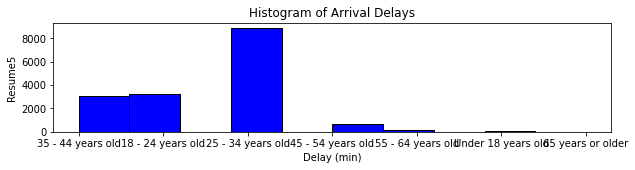

In [388]:
# matplotlib histogram
plt.hist(Resume5['Age'], color = 'blue', edgecolor = 'black')

# seaborn histogram
# sns.distplot(Resume4['Age'], hist=True, kde=False,color = 'blue',hist_kws={'edgecolor':'black'})
# Add labels
plt.rcParams['figure.figsize']=[10,2]
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Resume5')


In [389]:
pd.crosstab(Resume5['Age'],Resume5['Gender']).apply(lambda r: r*100/r.sum(), axis=1)

Gender                Female        Male  \
Age                                        
18 - 24 years old   5.246818   92.890407   
25 - 34 years old   6.559225   91.975656   
35 - 44 years old   4.221721   94.424750   
45 - 54 years old   4.191617   95.059880   
55 - 64 years old   3.597122   94.964029   
65 years or older   0.000000  100.000000   
Under 18 years old  0.000000  100.000000   

Gender              Non-binary, genderqueer, or gender non-conforming  \
Age                                                                     
18 - 24 years old                                            0.527786   
25 - 34 years old                                            0.462076   
35 - 44 years old                                            0.193361   
45 - 54 years old                                            0.299401   
55 - 64 years old                                            0.000000   
65 years or older                                            0.000000   
Under 18 years old                                           0.000000   

Gender                 other  
Age                           
18 - 24 years old   1.334989  
25 - 34 years old   1.003043  
35 - 44 years old   1.160168  
45 - 54 years old   0.449102  
55 - 64 years old   1.438849  
65 years or older   0.000000  
Under 18 years old  0.000000

In [390]:
pd.crosstab(Resume5['Age'],Resume5['Salary_group']).apply(lambda r: r*100/r.sum(), axis=1)

Salary_group         500-1500  1501-5000  5001-10000  10001-16000  \
Age                                                                 
18 - 24 years old   13.505123  37.038187   19.900652     5.246818   
25 - 34 years old    3.426124  33.618844   31.037980     9.275330   
35 - 44 years old    1.063487  25.233645   37.093136    19.658395   
45 - 54 years old    0.748503  14.970060   42.215569    25.299401   
55 - 64 years old    0.719424  10.071942   37.410072    33.093525   
65 years or older    0.000000   0.000000   57.142857    28.571429   
Under 18 years old  70.370370  29.629630    0.000000     0.000000   

Salary_group        16001-30000  30001-45000  45001-63000  63001-79000  \
Age                                                                      
18 - 24 years old     10.090034     6.643899     3.415088     2.049053   
25 - 34 years old      5.623803     6.829708     4.868703     2.400541   
35 - 44 years old      4.898485     4.157267     3.996133     1.965840   
45 - 54 years old      6.437126     3.293413     2.844311     1.946108   
55 - 64 years old      6.474820     3.597122     5.035971     1.438849   
65 years or older     14.285714     0.000000     0.000000     0.000000   
Under 18 years old     0.000000     0.000000     0.000000     0.000000   

Salary_group        79001-89000  89001-100000  
Age                                            
18 - 24 years old      0.900342      1.210804  
25 - 34 years old      1.284797      1.634171  
35 - 44 years old      1.095714      0.837899  
45 - 54 years old      1.197605      1.047904  
55 - 64 years old      0.719424      1.438849  
65 years or older      0.000000      0.000000  
Under 18 years old     0.000000      0.000000

In [391]:
analysis = Resume5.groupby('Age')['Gender'].value_counts()
analysis

Age                 Gender                                           
18 - 24 years old   Male                                                 2992
                    Female                                                169
                    other                                                  43
                    Non-binary, genderqueer, or gender non-conforming      17
25 - 34 years old   Male                                                 8161
                    Female                                                582
                    other                                                  89
                    Non-binary, genderqueer, or gender non-conforming      41
35 - 44 years old   Male                                                 2930
                    Female                                                131
                    other                                                  36
                    Non-binary, genderqueer, or gender non-conforming   

In [392]:
Resume5

Respondent             Country         Student  \
1               3      United Kingdom              No   
6               9       United States              No   
8              11       United States              No   
17             27              Sweden              No   
20             33           Australia              No   
...           ...                 ...             ...   
71512      101569  Russian Federation              No   
71513      101570             Belgium              No   
71515      101572             Germany              No   
71524      101584       United States  Yes, full-time   
71526      101587              Canada              No   

                    CompanySize Dependents  \
1      10,000 or more employees        Yes   
6      10,000 or more employees         No   
8          100 to 499 employees        Yes   
17           10 to 19 employees        Yes   
20     1,000 to 4,999 employees        Yes   
...                         ...        ...   
71512        20 to 99 employees         No   
71513        20 to 99 employees         No   
71515        20 to 99 employees         No   
71524        20 to 99 employees         No   
71526   Fewer than 10 employees         No   

                                                 DevType Gender  \
1      [Database administrator, DevOps specialist, Fu...   Male   
6      [Back-end developer, Front-end developer, Full...   Male   
8      [Back-end developer, C-suite executive (CEO,  ...   Male   
17                                  [Back-end developer]   Male   
20     [Database administrator, Full-stack developer,...   Male   
...                                                  ...    ...   
71512                               [Back-end developer]   Male   
71513  [Back-end developer, Data or business analyst,...   Male   
71515  [C-suite executive (CEO,  CTO,  etc.), Front-e...   Male   
71524  [Back-end developer, C-suite executive (CEO,  ...   Male   
71526  [Back-end developer, Full-stack developer, Pro...   Male   

               JobSatisfaction                 LastNewJob  Salary_group  \
1      Moderately dissatisfied      More than 4 years ago     1501-5000   
6           Slightly satisfied       Less than a year ago    5001-10000   
8         Moderately satisfied  Between 2 and 4 years ago   16001-30000   
17        Moderately satisfied  Between 1 and 2 years ago   30001-45000   
20          Slightly satisfied  Between 2 and 4 years ago    5001-10000   
...                        ...                        ...           ...   
71512      Extremely satisfied       Less than a year ago  89001-100000   
71513     Moderately satisfied       Less than a year ago     1501-5000   
71515      Extremely satisfied       Less than a year ago     1501-5000   
71524      Extremely satisfied      More than 4 years ago   10001-16000   
71526      Extremely satisfied  Between 1 and 2 years ago    5001-10000   

             Salary SalaryType  \
1            4250.0     Yearly   
6           10000.0     Yearly   
8      20833.333333     Yearly   
17          32000.0    Monthly   
20          10000.0     Yearly   
...             ...        ...   
71512      100000.0    Monthly   
71513        3600.0    Monthly   
71515        2500.0    Monthly   
71524       13750.0     Yearly   
71526   6666.666667     Yearly   

                                      LanguageWorkedWith  \
1                           JavaScript,Python,Bash/Shell   
6                                    JavaScript,HTML,CSS   
8      Assembly,CoffeeScript,Erlang,Go,JavaScript,Lua...   
17                            C#,SQL,HTML,CSS,Bash/Shell   
20                             C,C++,Go,Python,SQL,Swift   
...                                                  ...   
71512                                           Java,SQL   
71513  CoffeeScript,Clojure,JavaScript,PHP,Rust,SQL,H...   
71515  CoffeeScript,JavaScript,PHP,SQL,HTML,CSS,Bash/...   
71524  C#,Clojure,Go,Java,JavaScript,PHP,R,SQL,HTML,C.

In [393]:
sub= Resume5[['Respondent','skills']]
aprioriData1 = pd.DataFrame(sub)
aprioriData1


Respondent                                             skills
1               3  [bash/shell, redis, postgresql, memcached, lin...
6               9  [node.js, html, linux, react, javascript, css,...
8              11  [amazon rds/aurora, ios, amazon redshift, sql,...
17             27  [bash/shell, c#, windows desktop or server, ht...
20             33  [node.js, go, ios, mac os, aws, redis, sql, an...
...           ...                                                ...
71512      101569  [redis, windows desktop or server, sql, postgr...
71513      101570  [angular, sql, memcached, rust, wordpress, mon...
71515      101572  [node.js, bash/shell, mac os, html, sql, coffe...
71524      101584  [c#, microsoft azure (tables, sql, postgresql,...
71526      101587  [amazon rds/aurora, c#, ios, sql, postgresql, ...

[16038 rows x 2 columns]

In [394]:
apridata = []
# Only take first 500 rows
count=500;
for index,data in aprioriData1.iterrows():
    eachapridata=[]
    eachapridata.append(data['Respondent'])
    eachapridata.append(data['skills'])
    apridata.append(eachapridata)
    count-=1
    if(count<=0):
        break
# print(apridata)
data=apridata
# data

In [395]:
init = []
for i in apridata:
    for q in i[1]:
        if(q not in init):
            init.append(q)
init = sorted(init)

print(len(init))

96


In [396]:
sp = 0.4
s = int(sp*len(init))
s

38

In [397]:
from collections import Counter
c = Counter()
for i in init:
    for d in data:
        if(i in d[1]):
            c[i]+=1
print("C1:")
for i in c:
    print(str([i])+": "+str(c[i]))
print()
l = Counter()
for i in c:
    if(c[i] >= s):
        l[frozenset([i])]+=c[i]
print("L1:")
for i in l:
    print(str(list(i))+": "+str(l[i]))
print()
pl = l
pos = 1
for count in range (2,1000):
    nc = set()
    temp = list(l)
    for i in range(0,len(temp)):
        for j in range(i+1,len(temp)):
            t = temp[i].union(temp[j])
            if(len(t) == count):
                nc.add(temp[i].union(temp[j]))
    nc = list(nc)
    c = Counter()
    for i in nc:
        c[i] = 0
        for q in data:
            temp = set(q[1])
            if(i.issubset(temp)):
                c[i]+=1
    print("C"+str(count)+":")
    for i in c:
        print(str(list(i))+": "+str(c[i]))
    print()
    l = Counter()
    for i in c:
        if(c[i] >= s):
            l[i]+=c[i]
    print("L"+str(count)+":")
    for i in l:
        print(str(list(i))+": "+str(l[i]))
    print()
    if(len(l) == 0):
        break
    pl = l
    pos = count
print("Result: ")
print("L"+str(pos)+":")
for i in pl:
    print(str(list(i))+": "+str(pl[i]))
print()

C1:
[' cosmosdb']: 51
[' sql']: 51
['.net core']: 146
['amazon dynamodb']: 32
['amazon echo']: 21
['amazon rds/aurora']: 37
['amazon redshift']: 15
['android']: 152
['angular']: 193
['apache hbase']: 9
['apache hive']: 13
['apple watch or apple tv']: 7
['arduino']: 49
['assembly']: 29
['aws']: 160
['azure']: 65
['bash/shell']: 242
['c']: 89
['c#']: 208
['c++']: 104
['cassandra']: 22
['clojure']: 6
['coffeescript']: 22
['cordova']: 42
['css']: 369
['delphi/object pascal']: 8
['django']: 65
['drupal']: 20
['elasticsearch']: 95
['erlang']: 7
['esp8266']: 16
['f#']: 15
['firebase']: 68
['gaming console']: 6
['go']: 58
['google bigquery']: 20
['google cloud platform/app engine']: 48
['google cloud storage']: 28
['google home']: 5
['groovy']: 30
['hadoop']: 25
['haskell']: 13
['heroku']: 72
['html']: 373
['ibm cloud or watson']: 11
['ibm db2']: 13
['ios']: 74
['java']: 231
['javascript']: 424
['julia']: 3
['kotlin']: 29
['linux']: 249
['lua']: 14
['mac os']: 97
['mainframe']: 3
['mariadb']: 

In [398]:
from itertools import combinations
for l in pl:
    c = [frozenset(q) for q in combinations(l,len(l)-1)]
    mmax = 0
    for a in c:
        b = l-a
        ab = l
        sab = 0
        sa = 0
        sb = 0
        for q in data:
            temp = set(q[1])
            if(a.issubset(temp)):
                sa+=1
            if(b.issubset(temp)):
                sb+=1
            if(ab.issubset(temp)):
                sab+=1
        temp = sab/sa*100
        if(temp > mmax):
            mmax = temp
        temp = sab/sb*100
        if(temp > mmax):
            mmax = temp
        print(str(list(a))+" -> "+str(list(b))+" = "+str(sab/sa*100)+"%")
        print(str(list(b))+" -> "+str(list(a))+" = "+str(sab/sb*100)+"%")
    curr = 1
    print("choosing:", end=' ')
    for a in c:
        b = l-a
        ab = l
        sab = 0
        sa = 0
        sb = 0
        for q in data:
            temp = set(q[1])
            if(a.issubset(temp)):
                sa+=1
            if(b.issubset(temp)):
                sb+=1
            if(ab.issubset(temp)):
                sab+=1
        temp = sab/sa*100
        if(temp == mmax):
            print(curr, end = ' ')
        curr += 1
        temp = sab/sb*100
        if(temp == mmax):
            print(curr, end = ' ')
        curr += 1
    print()
    print()

['node.js', 'bash/shell', 'html', 'sql', 'java', 'javascript', 'mysql'] -> ['css'] = 95.1219512195122%
['css'] -> ['node.js', 'bash/shell', 'html', 'sql', 'java', 'javascript', 'mysql'] = 10.569105691056912%
['node.js', 'bash/shell', 'html', 'sql', 'java', 'javascript', 'css'] -> ['mysql'] = 81.25%
['mysql'] -> ['node.js', 'bash/shell', 'html', 'sql', 'java', 'javascript', 'css'] = 14.028776978417264%
['node.js', 'bash/shell', 'html', 'sql', 'java', 'mysql', 'css'] -> ['javascript'] = 100.0%
['javascript'] -> ['node.js', 'bash/shell', 'html', 'sql', 'java', 'mysql', 'css'] = 9.19811320754717%
['node.js', 'bash/shell', 'html', 'sql', 'javascript', 'mysql', 'css'] -> ['java'] = 61.904761904761905%
['java'] -> ['node.js', 'bash/shell', 'html', 'sql', 'javascript', 'mysql', 'css'] = 16.883116883116884%
['node.js', 'bash/shell', 'sql', 'java', 'javascript', 'mysql', 'css'] -> ['html'] = 100.0%
['html'] -> ['node.js', 'bash/shell', 'sql', 'java', 'javascript', 'mysql', 'css'] = 10.4557640750

['mysql', 'css', 'html', 'node.js', 'sql', 'bash/shell', 'php'] -> ['javascript'] = 100.0%
<br>
['windows desktop or server', 'sql', 'javascript', 'c#', '.net core', 'css', 'sql server'] -> ['html'] = 97.91666666666666%
<br>
['mysql', 'linux', 'node.js', 'sql', 'javascript', 'bash/shell', 'css'] -> ['html'] = 97.5%


In [399]:
sub= Resume5[['Respondent','DevType']]
aprioriData2 = pd.DataFrame(sub)
aprioriData2

Respondent                                            DevType
1               3  [Database administrator, DevOps specialist, Fu...
6               9  [Back-end developer, Front-end developer, Full...
8              11  [Back-end developer, C-suite executive (CEO,  ...
17             27                               [Back-end developer]
20             33  [Database administrator, Full-stack developer,...
...           ...                                                ...
71512      101569                               [Back-end developer]
71513      101570  [Back-end developer, Data or business analyst,...
71515      101572  [C-suite executive (CEO,  CTO,  etc.), Front-e...
71524      101584  [Back-end developer, C-suite executive (CEO,  ...
71526      101587  [Back-end developer, Full-stack developer, Pro...

[16038 rows x 2 columns]

In [400]:
apridataD = []
# Only take first 500 rows
count=500;
for index,data in aprioriData2.iterrows():
    eachapridata=[]
    eachapridata.append(data['Respondent'])
    eachapridata.append(data['DevType'])
    apridataD.append(eachapridata)
    count-=1
    if(count<=0):
        break
# print(apridataD)
data=apridataD
# data

In [401]:
init = []
for i in apridataD:
    for q in i[1]:
        if(q not in init):
            init.append(q)
init = sorted(init)

print(len(init))

22


In [402]:
sp = 0.4
s = int(sp*len(init))
s

8

In [403]:
from collections import Counter
c = Counter()
for i in init:
    for d in data:
        if(i in d[1]):
            c[i]+=1
print("C1:")
for i in c:
    print(str([i])+": "+str(c[i]))
print()
l = Counter()
for i in c:
    if(c[i] >= s):
        l[frozenset([i])]+=c[i]
print("L1:")
for i in l:
    print(str(list(i))+": "+str(l[i]))
print()
pl = l
pos = 1
for count in range (2,1000):
    nc = set()
    temp = list(l)
    for i in range(0,len(temp)):
        for j in range(i+1,len(temp)):
            t = temp[i].union(temp[j])
            if(len(t) == count):
                nc.add(temp[i].union(temp[j]))
    nc = list(nc)
    c = Counter()
    for i in nc:
        c[i] = 0
        for q in data:
            temp = set(q[1])
            if(i.issubset(temp)):
                c[i]+=1
    print("C"+str(count)+":")
    for i in c:
        print(str(list(i))+": "+str(c[i]))
    print()
    l = Counter()
    for i in c:
        if(c[i] >= s):
            l[i]+=c[i]
    print("L"+str(count)+":")
    for i in l:
        print(str(list(i))+": "+str(l[i]))
    print()
    if(len(l) == 0):
        break
    pl = l
    pos = count
print("Result: ")
print("L"+str(pos)+":")
for i in pl:
    print(str(list(i))+": "+str(pl[i]))
print()

C1:
[' CTO']: 12
[' etc.)']: 12
['Back-end developer']: 332
['C-suite executive (CEO']: 12
['Data or business analyst']: 38
['Data scientist or machine learning specialist']: 37
['Database administrator']: 75
['Designer']: 47
['Desktop or enterprise applications developer']: 91
['DevOps specialist']: 72
['Educator or academic researcher']: 11
['Embedded applications or devices developer']: 22
['Engineering manager']: 30
['Front-end developer']: 218
['Full-stack developer']: 318
['Game or graphics developer']: 11
['Marketing or sales professional']: 4
['Mobile developer']: 91
['Product manager']: 24
['QA or test developer']: 30
['Student']: 30
['System administrator']: 67

L1:
[' CTO']: 12
[' etc.)']: 12
['Back-end developer']: 332
['C-suite executive (CEO']: 12
['Data or business analyst']: 38
['Data scientist or machine learning specialist']: 37
['Database administrator']: 75
['Designer']: 47
['Desktop or enterprise applications developer']: 91
['DevOps specialist']: 72
['Educator or 

In [404]:
from itertools import combinations
for l in pl:
    c = [frozenset(q) for q in combinations(l,len(l)-1)]
    mmax = 0
    for a in c:
        b = l-a
        ab = l
        sab = 0
        sa = 0
        sb = 0
        for q in data:
            temp = set(q[1])
            if(a.issubset(temp)):
                sa+=1
            if(b.issubset(temp)):
                sb+=1
            if(ab.issubset(temp)):
                sab+=1
        temp = sab/sa*100
        if(temp > mmax):
            mmax = temp
        temp = sab/sb*100
        if(temp > mmax):
            mmax = temp
        print(str(list(a))+" -> "+str(list(b))+" = "+str(sab/sa*100)+"%")
        print(str(list(b))+" -> "+str(list(a))+" = "+str(sab/sb*100)+"%")
    curr = 1
    print("choosing:", end=' ')
    for a in c:
        b = l-a
        ab = l
        sab = 0
        sa = 0
        sb = 0
        for q in data:
            temp = set(q[1])
            if(a.issubset(temp)):
                sa+=1
            if(b.issubset(temp)):
                sb+=1
            if(ab.issubset(temp)):
                sab+=1
        temp = sab/sa*100
        if(temp == mmax):
            print(curr, end = ' ')
        curr += 1
        temp = sab/sb*100
        if(temp == mmax):
            print(curr, end = ' ')
        curr += 1
    print()
    print()

['Desktop or enterprise applications developer', 'Database administrator', 'Full-stack developer', 'Back-end developer', 'DevOps specialist'] -> ['Front-end developer'] = 100.0%
['Front-end developer'] -> ['Desktop or enterprise applications developer', 'Database administrator', 'Full-stack developer', 'Back-end developer', 'DevOps specialist'] = 3.669724770642202%
['Desktop or enterprise applications developer', 'Database administrator', 'Full-stack developer', 'Back-end developer', 'Front-end developer'] -> ['DevOps specialist'] = 47.05882352941176%
['DevOps specialist'] -> ['Desktop or enterprise applications developer', 'Database administrator', 'Full-stack developer', 'Back-end developer', 'Front-end developer'] = 11.11111111111111%
['Desktop or enterprise applications developer', 'Database administrator', 'Full-stack developer', 'DevOps specialist', 'Front-end developer'] -> ['Back-end developer'] = 100.0%
['Back-end developer'] -> ['Desktop or enterprise applications developer',

['Database administrator', 'Mobile developer', 'System administrator', 'Full-stack developer', 'Back-end developer'] -> ['Front-end developer'] = 100.0%
['Database administrator', 'Mobile developer', 'System administrator', 'Full-stack developer', 'Front-end developer'] -> ['Back-end developer'] = 100.0%
['Database administrator', 'Mobile developer', 'System administrator', 'Back-end developer', 'Front-end developer'] -> ['Full-stack developer'] = 100.0%
['Mobile developer', 'System administrator', 'Full-stack developer', 'Back-end developer', 'Front-end developer'] -> ['Database administrator'] = 100.0%

['Back-end developer'] -> ['Database administrator', 'System administrator', 'Full-stack developer', 'DevOps specialist', 'Front-end developer'] = 2.898550724637681%
['Database administrator', 'System administrator', 'Back-end developer', 'DevOps specialist', 'Front-end developer'] -> ['Full-stack developer'] = 100.0%
['Desktop or enterprise applications developer', 'Database administrator', 'Designer', 'Full-stack developer', 'Back-end developer'] -> ['Front-end developer'] = 100.0%
['Desktop or enterprise applications developer', 'Database administrator', 'Designer', 'Full-stack developer', 'Front-end developer'] -> ['Back-end developer'] = 100.0%

In [405]:
apridataD = []
# Only take first 500 rows
count=11919;
for index,data in Resume5.iterrows():
    eachapridata=[]
    # eachapridata.append(data['skills'])
    apridataD.append(data['skills'])
    count-=1
    if(count<=0):
        break
# print(apridataD)
data=apridataD
data

[['bash/shell',
  'redis',
  'postgresql',
  'memcached',
  'linux',
  'django',
  'javascript',
  'python'],
 ['node.js', 'html', 'linux', 'react', 'javascript', 'css', 'mongodb'],
 ['amazon rds/aurora',
  'ios',
  'amazon redshift',
  'sql',
  'postgresql',
  'apache hbase',
  'amazon echo',
  'node.js',
  'aws',
  'apache hive',
  'html',
  'coffeescript',
  'linux',
  'lua',
  'amazon dynamodb',
  'python',
  'erlang',
  'bash/shell',
  'mac os',
  'serverless',
  'react',
  'elasticsearch',
  'spark',
  'ruby',
  'assembly',
  'go',
  'redis',
  'javascript',
  'hadoop',
  'css'],
 ['bash/shell',
  'c#',
  'windows desktop or server',
  'html',
  'sql',
  'sql server',
  'linux',
  '.net core',
  'css'],
 ['node.js',
  'go',
  'ios',
  'mac os',
  'aws',
  'redis',
  'sql',
  'android',
  'sqlite',
  'angular',
  'swift',
  'firebase',
  'c++',
  'postgresql',
  'linux',
  'python',
  'c'],
 ['angular',
  'ios',
  'sql',
  'android',
  'cordova',
  'swift',
  'firebase',
  'c++',


In [406]:
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df, min_support=0.2, use_colnames=True)
frequent_itemsets

support                             itemsets
0    0.844534                         (javascript)
1    0.495511                         (bash/shell)
2    0.487373                              (linux)
3    0.417820                             (python)
4    0.376122                         (postgresql)
..        ...                                  ...
469  0.200772                (angular, typescript)
470  0.244651       (typescript, javascript, html)
471  0.244232              (typescript, css, html)
472  0.242386        (javascript, typescript, css)
473  0.237939  (javascript, typescript, css, html)

[474 rows x 2 columns]

In [407]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.9
)

antecedents         consequents  antecedent support  \
0          (bash/shell, javascript)              (html)            0.432503   
1                (bash/shell, html)        (javascript)            0.417652   
2                 (bash/shell, css)              (html)            0.406410   
3                (bash/shell, html)               (css)            0.417652   
4                 (bash/shell, css)        (javascript)            0.406410   
..                              ...                 ...                 ...   
568   (css, typescript, javascript)              (html)            0.242386   
569  (typescript, javascript, html)               (css)            0.244651   
570         (typescript, css, html)        (javascript)            0.244232   
571               (typescript, css)  (javascript, html)            0.248846   
572              (typescript, html)   (css, javascript)            0.251279   

     consequent support   support  confidence      lift  leverage  conviction  
0              0.786391  0.394664    0.912512  1.160379  0.054548    2.441579  
1              0.844534  0.394664    0.944958  1.118910  0.041942    2.824489  
2              0.786391  0.400621    0.985756  1.253518  0.081024   14.995938  
3              0.763487  0.400621    0.959221  1.256368  0.081749    5.799815  
4              0.844534  0.387281    0.952931  1.128352  0.044054    3.302972  
..                  ...       ...         ...       ...       ...         ...  
568            0.786391  0.237939    0.981655  1.248303  0.047329   11.643680  
569            0.763487  0.237939    0.972565  1.273847  0.051151    8.620904  
570            0.844534  0.237939    0.974236  1.153578  0.031677    6.034156  
571            0.739743  0.237939    0.956170  1.292570  0.053857    5.937857  
572            0.723047  0.237939    0.946912  1.309612  0.056252    5.216815  

[573 rows x 9 columns]

In [408]:
apridataD = []
# Only take first 500 rows
count=11919;
for index,data in Resume5.iterrows():
    eachapridata=[]
    # eachapridata.append(data['skills'])
    apridataD.append(data['DevType'])
    count-=1
    if(count<=0):
        break
# print(apridataD)
data=apridataD
data

[['Database administrator',
  'DevOps specialist',
  'Full-stack developer',
  'System administrator'],
 ['Back-end developer', 'Front-end developer', 'Full-stack developer'],
 ['Back-end developer',
  'C-suite executive (CEO',
  ' CTO',
  ' etc.)',
  'Data or business analyst',
  'Database administrator',
  'DevOps specialist',
  'Engineering manager',
  'Full-stack developer',
  'System administrator'],
 ['Back-end developer'],
 ['Database administrator', 'Full-stack developer', 'Mobile developer'],
 ['Mobile developer'],
 ['Back-end developer', 'Engineering manager'],
 ['Back-end developer',
  'Database administrator',
  'DevOps specialist',
  'Front-end developer',
  'Full-stack developer',
  'Mobile developer'],
 ['Back-end developer',
  'Desktop or enterprise applications developer',
  'Front-end developer',
  'Full-stack developer'],
 ['Back-end developer', 'Full-stack developer'],
 ['Back-end developer',
  'Desktop or enterprise applications developer',
  'Embedded applications

In [409]:
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df, min_support=0.2, use_colnames=True)
frequent_itemsets

support                                           itemsets
0  0.650726                             (Full-stack developer)
1  0.684118                               (Back-end developer)
2  0.438627                              (Front-end developer)
3  0.462791         (Full-stack developer, Back-end developer)
4  0.358923          (Back-end developer, Front-end developer)
5  0.351456        (Full-stack developer, Front-end developer)
6  0.315966  (Full-stack developer, Back-end developer, Fro...

In [410]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)

antecedents             consequents  \
0                        (Front-end developer)    (Back-end developer)   
1                        (Front-end developer)  (Full-stack developer)   
2  (Full-stack developer, Front-end developer)    (Back-end developer)   
3    (Back-end developer, Front-end developer)  (Full-stack developer)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.438627            0.684118  0.358923    0.818286  1.196119   
1            0.438627            0.650726  0.351456    0.801262  1.231337   
2            0.351456            0.684118  0.315966    0.899021  1.314132   
3            0.358923            0.650726  0.315966    0.880318  1.352825   

   leverage  conviction  
0  0.058850    1.738350  
1  0.066030    1.757465  
2  0.075529    3.128205  
3  0.082406    2.918350

Text(0.5, 1.0, 'Resume')

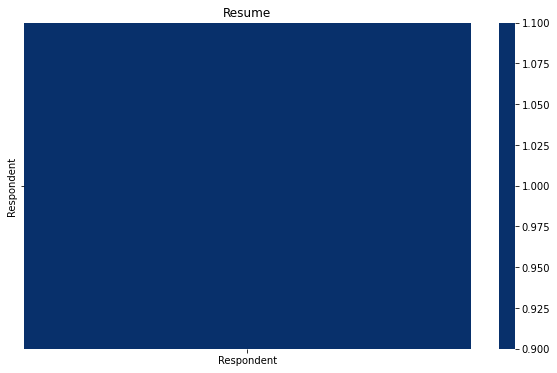

In [411]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(Resume5.corr(), center=0, cmap='Blues')
ax.set_title('Resume')

In [412]:
Resume5.dtypes

Respondent                int64
Country                  object
Student                  object
CompanySize              object
Dependents               object
DevType                  object
Gender                   object
JobSatisfaction          object
LastNewJob               object
Salary_group           category
Salary                   object
SalaryType               object
LanguageWorkedWith       object
DatabaseWorkedWith       object
PlatformWorkedWith       object
FrameworkWorkedWith      object
OperatingSystem          object
Age                      object
skills                   object
dtype: object

### Build Graph on Neo4j


In [413]:
Resume5.head()

Respondent         Country Student               CompanySize Dependents  \
1            3  United Kingdom      No  10,000 or more employees        Yes   
6            9   United States      No  10,000 or more employees         No   
8           11   United States      No      100 to 499 employees        Yes   
17          27          Sweden      No        10 to 19 employees        Yes   
20          33       Australia      No  1,000 to 4,999 employees        Yes   

                                              DevType Gender  \
1   [Database administrator, DevOps specialist, Fu...   Male   
6   [Back-end developer, Front-end developer, Full...   Male   
8   [Back-end developer, C-suite executive (CEO,  ...   Male   
17                               [Back-end developer]   Male   
20  [Database administrator, Full-stack developer,...   Male   

            JobSatisfaction                 LastNewJob Salary_group  \
1   Moderately dissatisfied      More than 4 years ago    1501-5000   
6        Slightly satisfied       Less than a year ago   5001-10000   
8      Moderately satisfied  Between 2 and 4 years ago  16001-30000   
17     Moderately satisfied  Between 1 and 2 years ago  30001-45000   
20       Slightly satisfied  Between 2 and 4 years ago   5001-10000   

          Salary SalaryType  \
1         4250.0     Yearly   
6        10000.0     Yearly   
8   20833.333333     Yearly   
17       32000.0    Monthly   
20       10000.0     Yearly   

                                   LanguageWorkedWith  \
1                        JavaScript,Python,Bash/Shell   
6                                 JavaScript,HTML,CSS   
8   Assembly,CoffeeScript,Erlang,Go,JavaScript,Lua...   
17                         C#,SQL,HTML,CSS,Bash/Shell   
20                          C,C++,Go,Python,SQL,Swift   

                                   DatabaseWorkedWith  \
1                          Redis,PostgreSQL,Memcached   
6                                             MongoDB   
8   Redis,PostgreSQL,Amazon DynamoDB,Apache HBase,...   
17                                         SQL Server   
20                            Redis,PostgreSQL,SQLite   

                             PlatformWorkedWith         FrameworkWorkedWith  \
1                                         Linux                      Django   
6                                         Linux               Node.js,React   
8   Amazon Echo,AWS,iOS,Linux,Mac OS,Serverless  Hadoop,Node.js,React,Spark   
17              Linux,Windows Desktop or Server                   .NET Core   
20        Android,AWS,iOS,Linux,Mac OS,Firebase             Angular,Node.js   

   OperatingSystem                Age  \
1      Linux-based  35 - 44 years old   
6            MacOS  18 - 24 years old   
8            MacOS  35 - 44 years old   
17         Windows  35 - 44 years old   
20           MacOS  35 - 44 years old   

                                               skills  
1   [bash/shell, redis, postgresql, memcached, lin...  
6   [node.js, html, linux, react, javascript, css,...  
8   [amazon rds/aurora, ios, amazon redshift, sql,...  
17  [bash/shell, c#, windows desktop or server, ht...  
20  [node.js, go, ios, mac os, aws, redis, sql, an...

In [414]:
from neo4j import GraphDatabase
import logging
from neo4j.exceptions import ServiceUnavailable

class App:

    def __uniqueSkillsList__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        # Don't forget to close the driver connection when you are finished with it
        self.driver.close()

    def create_friendship(self, person1_name,skillVal,gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal):
        with self.driver.session() as session:
            # Write transactions allow the driver to handle retries and transient errors
            result = session.write_transaction(
                self._create_and_return_friendship, person1_name,skillVal,gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal)
            for row in result:
                print("Created Node between: {p1}, {p2}".format(p1=row['p1'], p2=row['p2']))

    @staticmethod
    def _create_and_return_friendship(tx, person1_name, skillVal ,gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal):
        # To learn more about the Cypher syntax, see https://neo4j.com/docs/cypher-manual/current/
        # The Reference Card is also a good resource for keywords https://neo4j.com/docs/cypher-refcard/current/
        query = (
            "MERGE (p1:ResumeId { name: $person1_name }) "
            "MERGE (p2:Gender { name: $gednerVal }) "
            "MERGE (p3:OperatingSystem { name: $osNameVal }) "
            "MERGE (p4:Country { name: $countryNameVal }) "
            "MERGE (p5:Salery { name: $saleryVal }) "
            "MERGE (p6:DevType { name: $devTypeVal }) "
            "MERGE (p7:Age { name: $ageVal }) "
            "MERGE (p8:Dependents { name: $dependsVal }) "
            "CREATE (p1)-[:isA]->(p2) "
            "CREATE (p1)-[:hasOs]->(p3) "
            "CREATE (p1)-[:livesIn]->(p4) "
            "CREATE (p1)-[:earns]->(p5) "
            "CREATE (p1)-[:worksOn]->(p6) "
            "CREATE (p1)-[:liesIn]->(p7) "
            "CREATE (p1)-[:has]->(p8) "
            "RETURN p1,p2,p3,p4,p5,p6,p7,p8"
        )
        result = tx.run(query, person1_name=person1_name,gednerVal=gednerVal,osNameVal=osNameVal,countryNameVal=countryNameVal,saleryVal=saleryVal,devTypeVal=devTypeVal,ageVal=ageVal,dependsVal=dependsVal )
        try:
            return [{"p1": row["p1"]["name"], "p2": row["p2"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    def find_person(self, person_name):
        with self.driver.session() as session:
            result = session.read_transaction(self._find_and_return_person, person_name)
            for row in result:
                print("Found person: {row}".format(row=row))

    @staticmethod
    def _find_and_return_person(tx, person_name):
        query = (
            "MATCH (p:Person) "
            "WHERE p.name = $person_name "
            "RETURN p.name AS name"
        )
        result = tx.run(query, person_name=person_name)
        return [row["name"] for row in result]


if __name__ == "__main__":
    # Aura queries use an encrypted connection using the "neo4j+s" URI scheme
    uri = "neo4j://localhost:7687"
    user = "neo4j"
    password = "amit"
    app = App(uri, user, password)
    for index,rows in Resume5.iterrows():
        resId=rows['Respondent'] 
        skillVal=rows['skills']
        gednerVal=rows['Gender']
        osNameVal=rows['OperatingSystem']
        countryNameVal=rows['Country']
        saleryVal=rows['Salary']
        devTypeVal=rows['DevType']
        ageVal=rows['Age']
        dependsVal=rows['Dependents']
        # print(resId,gednerVal)
        app.create_friendship(resId,skillVal,gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal)
    app.find_person("India")
    app.close()

TypeError: App() takes no arguments